# Example Notebook importing & using a Keras implementation of Leela-Zero

---

Created by Willem Hendriks, whendrik@gmail.com

importing libraries

In [1]:
import numpy as np
import os
import tensorflow

from tensorflow.keras.models import load_model

## List all available models

In [2]:
for filename in os.listdir():
    if ".h5" in filename:
        print(filename)

leelazero_10x128.h5
leelazero_1x8.h5
leelazero_6x128.h5
leelazero_4x32.h5
leelazero_5x64.h5


## Basic board situations

To use Leela-Zero, a board situation has to be encoded to a 18 planes encoding. The Keras implementation is in channel-last format, making a 19x19 board, a (19,19,18) vector.

A function do to this for a given `.sgf` file is still on the todo list.

In [3]:
def empty_board():
    empty_board = np.zeros([19,19,18])
    empty_board[:,:,16]  =  empty_board[:,:,16] + 1
    return empty_board

def black_first_move():
    empty_board = np.zeros([19,19,18])
    empty_board[3,3,8] = 1.0
    empty_board[:,:,17]  =  empty_board[:,:,17] + 1
    return empty_board

## Load a network

In Keras, a `model.summary()` will output the architecture of the model, and a `model.predict()` will score the network on input data, i.e.

```
predictions = model.predict( board_situations )
```

### Output

For `N` board situations, the output is a list of length 2;

1. First element, being a `N x 362` vector, containing 362, logits probabilities for all 361 intersection and the pass move, for `N` board positions.
2. Second element, a `N x 1`, for each board posisiont `N`, a tanh nonlinearity outputting a scalar in range `[-1,1]`, which can be transformed to the probability to win for player to move.

In [4]:
model = load_model("leelazero_5x64.h5")

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
predictions = model.predict( np.expand_dims(empty_board(),0))
policy_outputs, value_outputs = predictions

In [6]:
policy_outputs.shape

(1, 362)

## Calculate the chance of winning for Player-to-Move

In [7]:
chance_to_win_for_player_to_move = (1.0 + np.tanh(value_outputs)) / 2.0

print("Chance to win: {}".format(chance_to_win_for_player_to_move[0]))

Chance to win: [0.440311]


## Plot a heatmap of the predictions

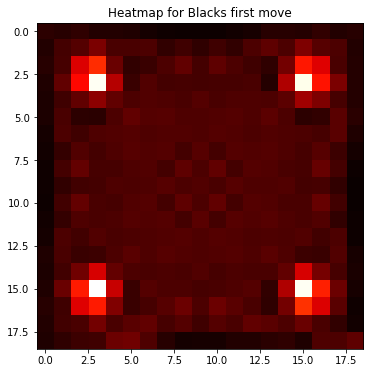

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

policy_heatmap = predictions[0][0][:361].reshape([19,19])
plt.figure(figsize=(6,6))
im = plt.imshow(policy_heatmap, cmap='hot', interpolation='nearest')
plt.title("Heatmap for Blacks first move")
plt.show()

## Plot a heatmap of hidden layers

What is Leela-Zero's view on the board situation? Well, a 20x256 network, has 20 blocks, with each two times 256 filters. Filters can be interpreted as different interpretations of the input. For images, this sometimes is losely translated to filters that are detecting edges, or smooth surfaces.

We are going to plot the first few filter, of the first Convolution, of the first block.
To view a list of available layers, `model.summary()`

We need to define a sub-model first, outputting the filters of the first block.

In [9]:
from tensorflow.keras.models import Model

sub_model = model.get_layer("b_residual_1_0_relu").output
sub_out = Model(inputs=model.input, outputs=sub_model)

In [10]:
inner_filters = sub_out.predict(np.expand_dims(empty_board(),axis=0))

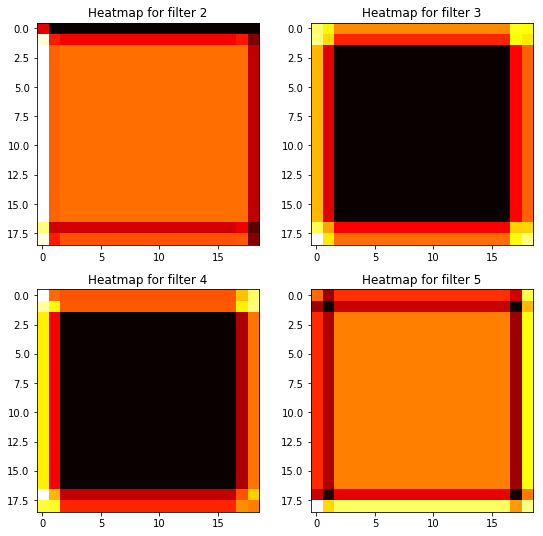

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np


filter_number = 1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9))

for row in ax:
    for col in row:
        filter_number = filter_number + 1
        policy_heatmap = inner_filters[0][:,:,filter_number]
        col.imshow(policy_heatmap, cmap='hot', interpolation='nearest')
        col.set_title("Heatmap for filter {}".format(filter_number))
plt.show()